In [ ]:
import json
import logging
import os
import typing

_log_format = (
    '{"time":"%(asctime)s", "name": "%(name)s",'
    ' "file": "%(filename)s", "func": "%(funcName)s", "line": %('
    'lineno)d, "level": "%(levelname)s", "message": %(message)s}'
)
_datefmt = "%d-%b-%y %H:%M:%S"
logger_level: str = os.getenv("LOGGING_LEVEL", "INFO")
    
def _get_stream_handler() -> logging.StreamHandler:  # type: ignore
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logger_level)
    stream_handler.setFormatter(logging.Formatter(_log_format, _datefmt))
    return stream_handler


def get_logger(name: str) -> logging.Logger:
    logger = logging.getLogger(name)
    logger.setLevel(logger_level)
    logger.addHandler(_get_stream_handler())
    return logger


def json_msg(msg: typing.Any) -> str:
    return json.dumps(msg)

logger = get_logger("note")

## What to do

1. LSTM student
    1. get code from article
    2. try your own model with fasttext embeddings for example
2. small BERT student
    1. remove next sentence predictions at all
        for now they will be ignored
    2. try to get weights from original bert
    3. try to train from scratch
    4. try to get another init waights
    5. lottery tiket [hipothesis](https://arxiv.org/abs/1803.03635)

In [2]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# model = AutoModelForSequenceClassification.from_pretrained("Tatyana/rubert-base-cased-sentiment-new")
# model.eval()
# tokenizer = AutoTokenizer.from_pretrained("Tatyana/rubert-base-cased-sentiment-new", return_tensors="pt")

# inp = tokenizer(["привет что делаешь"], return_tensors="pt")
# model(**inp)

### Dataset

In [19]:
# from datasets import load_dataset
# df = load_dataset("Tatyana/ru_sentiment_dataset")

In [ ]:
# 0: NEUTRAL
# 1: POSITIVE
# 2: NEGATIVE

In [5]:
import pandas as pd
import json
from collections import Counter

EMB_PATH = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
DF_PATH = "train.csv"

In [42]:
df = pd.read_csv(DF_PATH)[['text', "sentiment"]]
#n = 30000
#df = df[:n]
# Counter(df['sentiment'][:n])

NameError: name 'n' is not defined

In [7]:
import torch
import numpy as np
from navec import Navec
from razdel import tokenize as razdel_tokenizer
# from segtok.tokenizer import word_tokenizer

class CustomEmbeddings:
    def __init__(self, path, unk="<unk>"):
        self.emb = Navec.load(path)
        self.unk = unk
    
    def _convert(self, list_):
        """UserWarning: Creating a tensor from a list
        of numpy.ndarrays is extremely slow. 
        
        Please consider converting the list to a single
        numpy.ndarray with numpy.array() before converting to a tensor."""
        return torch.as_tensor(np.array(list_))
    
    def __call__(self, tokens):
        return self._convert([self.emb.get(x, self.emb[self.unk]) for x in tokens])

# TODO: rewrite with vocab when emb=None
# TODO: rewrite to use it in collator
class Tokenizer:
    def __init__(self, emb, unk_token="<unk>", pad_token="<pad>"):
        if not emb:
            logger.warning("NO EMBEDDINGS!")
        self.emb = self._load_emb(emb)
    
    def tokenize(self, text):
        return [_.text for _ in razdel_tokenizer(text)]
    
    def __call__(self, text):
        return self.emb([_.text for _ in razdel_tokenizer(text)])
    
    def _load_emb(self, path):
        return CustomEmbeddings(path)

In [8]:
tokenizer = Tokenizer(EMB_PATH)

In [9]:
(tokenizer("какой-то текст на русском"))

tensor([[-0.2056, -0.5172, -0.1197,  ..., -0.1694, -0.2201,  0.8499],
        [-0.6365, -0.1460,  0.5631,  ..., -0.4420, -0.1768,  0.5108],
        [ 0.0562, -0.4159, -0.0392,  ..., -0.0266, -0.1075,  0.5631],
        [-0.2772, -0.3065,  0.2907,  ..., -0.4420, -0.1768,  0.5108]])

In [10]:
from itertools import chain

import pandas as pd
import torch
from tqdm import tqdm

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from segtok.tokenizer import word_tokenizer


class VocabDataset(Dataset):
    def __init__(self, data_path, text_col="text", target_col="sentiment", tokenizer=None, pad_token="<PAD>", unk_token="<UNK>"):
        X, y = zip(*pd.read_csv(data_path)[[text_col, target_col]].to_numpy())
        
        self.tokenizer = tokenizer or str.split

        self.X = [self.tokenizer(x) for x in X]
        self.y = y

        self.vocab = dict([(x, i) for i, x in enumerate(set(chain.from_iterable(self.X)), start=1)])
        self.vocab[pad_token] = 0
        self.vocab[unk_token] = len(self.vocab)
        self.vocab_len = len(self.vocab)

        self.X = [self.vocab_encode(x) for x in self.X]

    def vocab_encode(self, seq):
        return torch.tensor([self.vocab[tok] for tok in seq])

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
class EmbDataset(Dataset):
    def __init__(self, data_path, tokenizer, size=None, text_col="text", target_col="sentiment", mean=True):
        self.X, self.y = zip(*pd.read_csv(data_path)[[text_col, target_col]][:size].to_numpy())
        
        self.tokenizer = tokenizer

        self.X = [self.tokenizer(x) for x in tqdm(self.X)]
        if mean:
            self.X = [x.mean(0) for x in tqdm(self.X)]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)


class Collator:
    def __init__(self, pad_value=0):
        pass

    def __call__(self, batch):
        feats, labels = zip(*batch)
        lens = [len(x) for x in feats]
        feats = pad_sequence(feats, batch_first=True)
        return feats, torch.tensor(labels), lens

In [31]:
dataset = EmbDataset("train.csv", tokenizer, size=50000)

dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=0)
#                         collate_fn=Collator())

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 23142.87it/s]


In [32]:
# for x in dataset:
#     print(x)
#     break

### LinearModel

In [33]:
from pathlib import Path
from torch import nn
from tqdm import tqdm
from torch.nn import functional as F

class MeanClassifier(nn.Module):
    def __init__(self, vocab, emb_dim=256, hid_dim=512, num_classes=3):
        super().__init__()
        self.vocab = vocab
        self.embed = nn.Embedding(len(self.vocab),
                                  embedding_dim=emb_dim,
                                  padding_idx=0)
        self.linear_hid1 = nn.Linear(emb_dim, hid_dim)
        self.linear_hid2 = nn.Linear(hid_dim, hid_dim)
        self.linear_hid3 = nn.Linear(hid_dim, hid_dim)
        self.linear_out = nn.Linear(hid_dim, num_classes)

    def forward(self, x):
        # TODO: batch_first=False
        # TODO: weighted mean
        x = torch.mean(self.embed(x), 1)
        x = F.relu(self.linear_hid1(x))
        x = F.relu(self.linear_hid2(x))
        x = F.relu(self.linear_hid3(x))
        return self.linear_out(x)

    def save(self, folder):
        folder = Path(folder).absolute()
        folder.mkdir(parents=True, exist_ok=True)

        with open(folder / "vocab.json", 'w') as file:
            json.dump(self.vocab, file)

        torch.save(self.state_dict(), folder / "model.pt")
        
class EmbClassifier(nn.Module):
    def __init__(self, emb_dim=300, hid_dim=512, num_classes=3):
        super().__init__()
        self.linear_hid1 = nn.Linear(emb_dim, hid_dim)
        self.linear_hid2 = nn.Linear(hid_dim, hid_dim)
        self.linear_hid3 = nn.Linear(hid_dim, hid_dim)
        self.linear_out = nn.Linear(hid_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.linear_hid1(x))
        x = F.relu(self.linear_hid2(x))
        x = F.relu(self.linear_hid3(x))
        return self.linear_out(x)

    def save(self, folder):
        folder = Path(folder).absolute()
        folder.mkdir(parents=True, exist_ok=True)

        torch.save(self.state_dict(), folder / "model.pt")

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.empty_cache()

if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [35]:
model = EmbClassifier(emb_dim=300, hid_dim=512)
model = model.to(device)

n_epochs = 10
lr=0.00001
clip = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=lr)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
#                                                 steps_per_epoch=len(dataloader), epochs=n_epochs)


In [36]:
data_len = len(dataloader)

model.train()

loss_array = []

for epoch in range(1, n_epochs + 1):
    for i, batch in tqdm(enumerate(dataloader), total=data_len):
        optimizer.zero_grad()
        output = model(batch[0].to(device))
        output = output.to(device)
        target_seq = batch[1].to(device)
#         print(target_seq.view(-1).long().shape)
#         print(output.shape)
        loss = criterion(output, target_seq)
        loss_array.append(loss.item())
        loss.backward()
        # TODO: google about usage
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        #scheduler.step()
        if i%400 == 0:
            print('Batch_100: {}/{}.............'.format(int(i/400), int(data_len/400) + 1), end=' ')
            print("Loss: {:.4f}".format(loss.item()))
    model.save(f"models{epoch}")

  0%|                                                                              | 19/12500 [00:00<01:06, 186.68it/s]

Batch_100: 0/32............. Loss: 1.1145


  4%|██▋                                                                          | 438/12500 [00:01<00:36, 327.71it/s]

Batch_100: 1/32............. Loss: 1.0691


  7%|█████▎                                                                       | 865/12500 [00:02<00:36, 314.67it/s]

Batch_100: 2/32............. Loss: 0.9433


 10%|███████▋                                                                    | 1272/12500 [00:04<00:34, 325.03it/s]

Batch_100: 3/32............. Loss: 1.1589


 13%|█████████▉                                                                  | 1639/12500 [00:05<00:35, 302.83it/s]

Batch_100: 4/32............. Loss: 1.0023


 16%|████████████▍                                                               | 2055/12500 [00:06<00:33, 308.09it/s]

Batch_100: 5/32............. Loss: 0.7820


 20%|██████████████▉                                                             | 2452/12500 [00:07<00:31, 321.01it/s]

Batch_100: 6/32............. Loss: 0.7606


 23%|█████████████████▎                                                          | 2853/12500 [00:09<00:30, 315.93it/s]

Batch_100: 7/32............. Loss: 0.9487


 26%|███████████████████▊                                                        | 3260/12500 [00:10<00:29, 317.15it/s]

Batch_100: 8/32............. Loss: 1.0432


 29%|██████████████████████▏                                                     | 3658/12500 [00:11<00:26, 329.59it/s]

Batch_100: 9/32............. Loss: 0.6526


 32%|████████████████████████▍                                                   | 4029/12500 [00:12<00:26, 315.97it/s]

Batch_100: 10/32............. Loss: 0.8878


 36%|███████████████████████████                                                 | 4448/12500 [00:14<00:25, 316.50it/s]

Batch_100: 11/32............. Loss: 0.6938


 39%|█████████████████████████████▍                                              | 4841/12500 [00:15<00:22, 333.32it/s]

Batch_100: 12/32............. Loss: 0.9212


 42%|███████████████████████████████▉                                            | 5251/12500 [00:16<00:22, 315.84it/s]

Batch_100: 13/32............. Loss: 0.8649


 45%|██████████████████████████████████▎                                         | 5650/12500 [00:17<00:21, 311.59it/s]

Batch_100: 14/32............. Loss: 0.6718


 48%|████████████████████████████████████▊                                       | 6054/12500 [00:19<00:20, 322.23it/s]

Batch_100: 15/32............. Loss: 0.5682


 52%|███████████████████████████████████████▏                                    | 6446/12500 [00:20<00:19, 311.64it/s]

Batch_100: 16/32............. Loss: 0.6285


 55%|█████████████████████████████████████████▌                                  | 6840/12500 [00:21<00:17, 315.25it/s]

Batch_100: 17/32............. Loss: 0.7844


 58%|███████████████████████████████████████████▉                                | 7231/12500 [00:22<00:16, 314.87it/s]

Batch_100: 18/32............. Loss: 0.5377


 61%|██████████████████████████████████████████████▍                             | 7633/12500 [00:24<00:14, 331.69it/s]

Batch_100: 19/32............. Loss: 0.8479


 64%|████████████████████████████████████████████████▉                           | 8040/12500 [00:25<00:13, 327.35it/s]

Batch_100: 20/32............. Loss: 0.6084


 68%|███████████████████████████████████████████████████▍                        | 8462/12500 [00:26<00:12, 318.11it/s]

Batch_100: 21/32............. Loss: 0.6297


 71%|█████████████████████████████████████████████████████▊                      | 8858/12500 [00:28<00:11, 317.70it/s]

Batch_100: 22/32............. Loss: 0.6456


 74%|████████████████████████████████████████████████████████▏                   | 9243/12500 [00:29<00:10, 297.32it/s]

Batch_100: 23/32............. Loss: 0.8606


 77%|██████████████████████████████████████████████████████████▊                 | 9669/12500 [00:30<00:09, 309.98it/s]

Batch_100: 24/32............. Loss: 0.5486


 80%|████████████████████████████████████████████████████████████▎              | 10058/12500 [00:31<00:07, 308.09it/s]

Batch_100: 25/32............. Loss: 0.8658


 84%|██████████████████████████████████████████████████████████████▋            | 10452/12500 [00:33<00:06, 307.77it/s]

Batch_100: 26/32............. Loss: 0.5566


 87%|█████████████████████████████████████████████████████████████████          | 10845/12500 [00:34<00:05, 308.03it/s]

Batch_100: 27/32............. Loss: 0.5003


 90%|███████████████████████████████████████████████████████████████████▍       | 11232/12500 [00:35<00:04, 310.99it/s]

Batch_100: 28/32............. Loss: 1.1764


 93%|█████████████████████████████████████████████████████████████████████▉     | 11651/12500 [00:37<00:02, 302.99it/s]

Batch_100: 29/32............. Loss: 0.5147


 96%|████████████████████████████████████████████████████████████████████████▏  | 12031/12500 [00:38<00:01, 302.28it/s]

Batch_100: 30/32............. Loss: 0.4587


 99%|██████████████████████████████████████████████████████████████████████████▌| 12427/12500 [00:39<00:00, 317.71it/s]

Batch_100: 31/32............. Loss: 0.2953


  0%|▏                                                                             | 31/12500 [00:00<00:41, 303.18it/s]

Batch_100: 0/32............. Loss: 0.6724


  4%|██▊                                                                          | 460/12500 [00:01<00:37, 320.53it/s]

Batch_100: 1/32............. Loss: 1.2180


  7%|█████▎                                                                       | 856/12500 [00:02<00:36, 318.92it/s]

Batch_100: 2/32............. Loss: 0.8767


 10%|███████▌                                                                    | 1253/12500 [00:03<00:36, 311.63it/s]

Batch_100: 3/32............. Loss: 1.6590


 13%|██████████                                                                  | 1650/12500 [00:05<00:34, 315.38it/s]

Batch_100: 4/32............. Loss: 1.0026


 16%|████████████▍                                                               | 2047/12500 [00:06<00:32, 320.25it/s]

Batch_100: 5/32............. Loss: 0.7726


 19%|██████████████▊                                                             | 2436/12500 [00:07<00:32, 313.95it/s]

Batch_100: 6/32............. Loss: 0.3181


 23%|█████████████████▍                                                          | 2864/12500 [00:09<00:31, 309.73it/s]

Batch_100: 7/32............. Loss: 0.6046


 26%|███████████████████▊                                                        | 3267/12500 [00:10<00:27, 333.75it/s]

Batch_100: 8/32............. Loss: 0.9549


 29%|██████████████████████                                                      | 3631/12500 [00:11<00:27, 318.07it/s]

Batch_100: 9/32............. Loss: 0.5891


 32%|████████████████████████▋                                                   | 4062/12500 [00:12<00:26, 319.93it/s]

Batch_100: 10/32............. Loss: 0.8017


 36%|███████████████████████████                                                 | 4458/12500 [00:14<00:24, 327.21it/s]

Batch_100: 11/32............. Loss: 0.8151


 39%|█████████████████████████████▌                                              | 4860/12500 [00:15<00:23, 319.96it/s]

Batch_100: 12/32............. Loss: 1.1421


 42%|███████████████████████████████▉                                            | 5260/12500 [00:16<00:22, 323.81it/s]

Batch_100: 13/32............. Loss: 0.8215


 45%|██████████████████████████████████▍                                         | 5659/12500 [00:17<00:22, 310.60it/s]

Batch_100: 14/32............. Loss: 0.6957


 49%|████████████████████████████████████▉                                       | 6065/12500 [00:19<00:19, 331.39it/s]

Batch_100: 15/32............. Loss: 0.4572


 52%|███████████████████████████████████████▏                                    | 6443/12500 [00:20<00:18, 334.21it/s]

Batch_100: 16/32............. Loss: 0.5229


 55%|█████████████████████████████████████████▌                                  | 6841/12500 [00:21<00:17, 314.96it/s]

Batch_100: 17/32............. Loss: 0.5810


 58%|████████████████████████████████████████████                                | 7247/12500 [00:22<00:16, 328.10it/s]

Batch_100: 18/32............. Loss: 1.3977


 61%|██████████████████████████████████████████████▍                             | 7636/12500 [00:24<00:15, 313.79it/s]

Batch_100: 19/32............. Loss: 0.5716


 64%|████████████████████████████████████████████████▊                           | 8037/12500 [00:25<00:13, 327.19it/s]

Batch_100: 20/32............. Loss: 0.7481


 68%|███████████████████████████████████████████████████▎                        | 8447/12500 [00:26<00:11, 338.18it/s]

Batch_100: 21/32............. Loss: 0.6099


 71%|█████████████████████████████████████████████████████▊                      | 8844/12500 [00:27<00:11, 313.27it/s]

Batch_100: 22/32............. Loss: 0.0989


 74%|████████████████████████████████████████████████████████▏                   | 9235/12500 [00:29<00:10, 312.15it/s]

Batch_100: 23/32............. Loss: 2.1263


 77%|██████████████████████████████████████████████████████████▋                 | 9661/12500 [00:30<00:08, 321.73it/s]

Batch_100: 24/32............. Loss: 1.0938


 80%|████████████████████████████████████████████████████████████▎              | 10059/12500 [00:31<00:07, 319.34it/s]

Batch_100: 25/32............. Loss: 0.9761


 84%|██████████████████████████████████████████████████████████████▋            | 10454/12500 [00:32<00:06, 323.52it/s]

Batch_100: 26/32............. Loss: 0.8589


 87%|█████████████████████████████████████████████████████████████████▏         | 10855/12500 [00:34<00:05, 318.61it/s]

Batch_100: 27/32............. Loss: 1.1425


 90%|███████████████████████████████████████████████████████████████████▍       | 11247/12500 [00:35<00:03, 323.66it/s]

Batch_100: 28/32............. Loss: 0.8598


 93%|█████████████████████████████████████████████████████████████████████▉     | 11647/12500 [00:36<00:02, 314.37it/s]

Batch_100: 29/32............. Loss: 0.8740


 96%|████████████████████████████████████████████████████████████████████████▎  | 12042/12500 [00:37<00:01, 309.79it/s]

Batch_100: 30/32............. Loss: 1.0340


100%|██████████████████████████████████████████████████████████████████████████▊| 12459/12500 [00:39<00:00, 304.90it/s]

Batch_100: 31/32............. Loss: 0.9141


  0%|▎                                                                             | 56/12500 [00:00<00:44, 278.37it/s]

Batch_100: 0/32............. Loss: 0.2738


  4%|██▊                                                                          | 452/12500 [00:01<00:38, 314.62it/s]

Batch_100: 1/32............. Loss: 0.7256


  7%|█████▏                                                                       | 852/12500 [00:02<00:35, 327.80it/s]

Batch_100: 2/32............. Loss: 0.4922


 10%|███████▋                                                                    | 1258/12500 [00:03<00:34, 322.21it/s]

Batch_100: 3/32............. Loss: 1.0649


 13%|██████████                                                                  | 1662/12500 [00:05<00:35, 304.95it/s]

Batch_100: 4/32............. Loss: 0.5152


 16%|████████████▎                                                               | 2027/12500 [00:06<00:32, 319.56it/s]

Batch_100: 5/32............. Loss: 0.5490


 20%|██████████████▉                                                             | 2463/12500 [00:07<00:32, 310.70it/s]

Batch_100: 6/32............. Loss: 1.2433


 23%|█████████████████▎                                                          | 2850/12500 [00:08<00:30, 315.37it/s]

Batch_100: 7/32............. Loss: 1.2651


 26%|███████████████████▋                                                        | 3242/12500 [00:10<00:30, 302.27it/s]

Batch_100: 8/32............. Loss: 0.6195


 29%|██████████████████████▎                                                     | 3669/12500 [00:11<00:26, 330.67it/s]

Batch_100: 9/32............. Loss: 0.3590


 32%|████████████████████████▌                                                   | 4037/12500 [00:12<00:26, 319.80it/s]

Batch_100: 10/32............. Loss: 0.6953


 35%|██████████████████████████▉                                                 | 4437/12500 [00:13<00:25, 317.98it/s]

Batch_100: 11/32............. Loss: 0.9785


 39%|█████████████████████████████▍                                              | 4845/12500 [00:15<00:23, 330.55it/s]

Batch_100: 12/32............. Loss: 0.6110


 42%|███████████████████████████████▉                                            | 5244/12500 [00:16<00:22, 327.36it/s]

Batch_100: 13/32............. Loss: 0.6810


 45%|██████████████████████████████████▍                                         | 5662/12500 [00:17<00:21, 315.24it/s]

Batch_100: 14/32............. Loss: 0.9401


 48%|████████████████████████████████████▊                                       | 6062/12500 [00:19<00:19, 322.48it/s]

Batch_100: 15/32............. Loss: 0.6774


 51%|███████████████████████████████████████                                     | 6428/12500 [00:20<00:19, 314.01it/s]

Batch_100: 16/32............. Loss: 1.2534


 55%|█████████████████████████████████████████▋                                  | 6854/12500 [00:21<00:17, 316.38it/s]

Batch_100: 17/32............. Loss: 0.3845


 58%|████████████████████████████████████████████▏                               | 7262/12500 [00:22<00:16, 319.68it/s]

Batch_100: 18/32............. Loss: 0.4248


 61%|██████████████████████████████████████████████▌                             | 7662/12500 [00:24<00:15, 321.86it/s]

Batch_100: 19/32............. Loss: 0.9822


 64%|████████████████████████████████████████████████▉                           | 8052/12500 [00:25<00:14, 316.70it/s]

Batch_100: 20/32............. Loss: 0.2984


 68%|███████████████████████████████████████████████████▍                        | 8459/12500 [00:26<00:12, 332.87it/s]

Batch_100: 21/32............. Loss: 0.1564


 71%|█████████████████████████████████████████████████████▊                      | 8852/12500 [00:27<00:11, 320.30it/s]

Batch_100: 22/32............. Loss: 0.3545


 74%|████████████████████████████████████████████████████████▎                   | 9256/12500 [00:29<00:09, 325.94it/s]

Batch_100: 23/32............. Loss: 0.3184


 77%|██████████████████████████████████████████████████████████▋                 | 9655/12500 [00:30<00:08, 323.41it/s]

Batch_100: 24/32............. Loss: 0.3440


 80%|████████████████████████████████████████████████████████████▎              | 10054/12500 [00:31<00:07, 324.23it/s]

Batch_100: 25/32............. Loss: 0.9560


 84%|██████████████████████████████████████████████████████████████▋            | 10453/12500 [00:32<00:06, 317.82it/s]

Batch_100: 26/32............. Loss: 0.5830


 87%|████████████████████████████████████████████████████████████████▉          | 10828/12500 [00:34<00:05, 313.38it/s]

Batch_100: 27/32............. Loss: 1.2087


 90%|███████████████████████████████████████████████████████████████████▌       | 11260/12500 [00:35<00:03, 327.22it/s]

Batch_100: 28/32............. Loss: 0.7106


 93%|█████████████████████████████████████████████████████████████████████▉     | 11658/12500 [00:36<00:02, 318.44it/s]

Batch_100: 29/32............. Loss: 0.7944


 96%|████████████████████████████████████████████████████████████████████████▎  | 12056/12500 [00:37<00:01, 320.13it/s]

Batch_100: 30/32............. Loss: 1.3693


100%|██████████████████████████████████████████████████████████████████████████▋| 12456/12500 [00:39<00:00, 314.05it/s]

Batch_100: 31/32............. Loss: 0.6911


  0%|▏                                                                             | 30/12500 [00:00<00:41, 297.57it/s]

Batch_100: 0/32............. Loss: 0.4102


  4%|██▊                                                                          | 461/12500 [00:01<00:37, 321.77it/s]

Batch_100: 1/32............. Loss: 0.6562


  7%|█████▎                                                                       | 865/12500 [00:02<00:37, 313.44it/s]

Batch_100: 2/32............. Loss: 0.4568


 10%|███████▍                                                                    | 1230/12500 [00:03<00:35, 316.00it/s]

Batch_100: 3/32............. Loss: 0.6330


 13%|██████████                                                                  | 1664/12500 [00:05<00:33, 326.29it/s]

Batch_100: 4/32............. Loss: 0.8203


 16%|████████████▍                                                               | 2047/12500 [00:06<00:31, 337.09it/s]

Batch_100: 5/32............. Loss: 0.3703


 20%|██████████████▉                                                             | 2451/12500 [00:07<00:31, 317.33it/s]

Batch_100: 6/32............. Loss: 0.6486


 23%|█████████████████▎                                                          | 2851/12500 [00:08<00:29, 328.48it/s]

Batch_100: 7/32............. Loss: 0.4610


 26%|███████████████████▊                                                        | 3253/12500 [00:10<00:29, 315.63it/s]

Batch_100: 8/32............. Loss: 0.9588


 29%|██████████████████████                                                      | 3624/12500 [00:11<00:27, 319.38it/s]

Batch_100: 9/32............. Loss: 0.7443


 32%|████████████████████████▌                                                   | 4050/12500 [00:12<00:26, 322.52it/s]

Batch_100: 10/32............. Loss: 0.3142


 36%|███████████████████████████                                                 | 4452/12500 [00:13<00:26, 309.08it/s]

Batch_100: 11/32............. Loss: 0.4722


 39%|█████████████████████████████▌                                              | 4855/12500 [00:15<00:23, 332.08it/s]

Batch_100: 12/32............. Loss: 0.3279


 42%|███████████████████████████████▉                                            | 5256/12500 [00:16<00:23, 306.24it/s]

Batch_100: 13/32............. Loss: 0.1918


 45%|██████████████████████████████████▎                                         | 5652/12500 [00:17<00:21, 314.43it/s]

Batch_100: 14/32............. Loss: 0.8293


 48%|████████████████████████████████████▊                                       | 6048/12500 [00:18<00:20, 315.21it/s]

Batch_100: 15/32............. Loss: 0.6165


 51%|███████████████████████████████████████                                     | 6431/12500 [00:20<00:19, 308.90it/s]

Batch_100: 16/32............. Loss: 0.4529


 55%|█████████████████████████████████████████▌                                  | 6832/12500 [00:21<00:17, 318.20it/s]

Batch_100: 17/32............. Loss: 0.5206


 58%|████████████████████████████████████████████▏                               | 7276/12500 [00:22<00:15, 331.92it/s]

Batch_100: 18/32............. Loss: 0.6491


 61%|██████████████████████████████████████████████▍                             | 7645/12500 [00:23<00:14, 323.90it/s]

Batch_100: 19/32............. Loss: 0.7829


 64%|████████████████████████████████████████████████▉                           | 8042/12500 [00:25<00:14, 310.91it/s]

Batch_100: 20/32............. Loss: 0.6373


 68%|███████████████████████████████████████████████████▎                        | 8442/12500 [00:26<00:12, 318.76it/s]

Batch_100: 21/32............. Loss: 0.7515


 71%|█████████████████████████████████████████████████████▊                      | 8850/12500 [00:27<00:10, 343.39it/s]

Batch_100: 22/32............. Loss: 0.4135


 74%|████████████████████████████████████████████████████████▎                   | 9254/12500 [00:28<00:10, 303.43it/s]

Batch_100: 23/32............. Loss: 0.5678


 77%|██████████████████████████████████████████████████████████▋                 | 9652/12500 [00:30<00:09, 310.41it/s]

Batch_100: 24/32............. Loss: 0.3928


 80%|████████████████████████████████████████████████████████████▎              | 10048/12500 [00:31<00:07, 324.64it/s]

Batch_100: 25/32............. Loss: 0.3566


 84%|██████████████████████████████████████████████████████████████▋            | 10441/12500 [00:32<00:06, 319.89it/s]

Batch_100: 26/32............. Loss: 0.3246


 87%|█████████████████████████████████████████████████████████████████          | 10840/12500 [00:33<00:05, 304.59it/s]

Batch_100: 27/32............. Loss: 1.4009


 90%|███████████████████████████████████████████████████████████████████▍       | 11249/12500 [00:35<00:03, 317.37it/s]

Batch_100: 28/32............. Loss: 0.2155


 93%|█████████████████████████████████████████████████████████████████████▉     | 11653/12500 [00:36<00:02, 329.52it/s]

Batch_100: 29/32............. Loss: 0.3606


 96%|████████████████████████████████████████████████████████████████████████▏  | 12041/12500 [00:37<00:01, 311.58it/s]

Batch_100: 30/32............. Loss: 0.9608


100%|██████████████████████████████████████████████████████████████████████████▋| 12440/12500 [00:38<00:00, 319.87it/s]

Batch_100: 31/32............. Loss: 0.5551


  0%|▏                                                                             | 31/12500 [00:00<00:41, 302.24it/s]

Batch_100: 0/32............. Loss: 0.5378


  4%|██▊                                                                          | 456/12500 [00:01<00:38, 315.71it/s]

Batch_100: 1/32............. Loss: 1.3325


  7%|█████▎                                                                       | 859/12500 [00:02<00:36, 319.82it/s]

Batch_100: 2/32............. Loss: 0.5640


 10%|███████▍                                                                    | 1230/12500 [00:03<00:36, 313.01it/s]

Batch_100: 3/32............. Loss: 1.1907


 13%|██████████                                                                  | 1657/12500 [00:05<00:34, 311.25it/s]

Batch_100: 4/32............. Loss: 0.4251


 16%|████████████▌                                                               | 2061/12500 [00:06<00:31, 334.65it/s]

Batch_100: 5/32............. Loss: 0.2602


 20%|██████████████▉                                                             | 2459/12500 [00:07<00:32, 312.00it/s]

Batch_100: 6/32............. Loss: 0.3224


 23%|█████████████████▎                                                          | 2856/12500 [00:08<00:30, 320.59it/s]

Batch_100: 7/32............. Loss: 0.7225


 26%|███████████████████▊                                                        | 3256/12500 [00:10<00:28, 320.47it/s]

Batch_100: 8/32............. Loss: 0.8066


 29%|██████████████████████▏                                                     | 3653/12500 [00:11<00:28, 306.65it/s]

Batch_100: 9/32............. Loss: 0.6703


 32%|████████████████████████▌                                                   | 4049/12500 [00:12<00:26, 316.06it/s]

Batch_100: 10/32............. Loss: 0.9785


 36%|███████████████████████████                                                 | 4454/12500 [00:13<00:24, 329.65it/s]

Batch_100: 11/32............. Loss: 0.7271


 39%|█████████████████████████████▌                                              | 4861/12500 [00:15<00:23, 329.39it/s]

Batch_100: 12/32............. Loss: 0.7124


 42%|███████████████████████████████▉                                            | 5258/12500 [00:16<00:24, 290.47it/s]

Batch_100: 13/32............. Loss: 0.3798


 45%|██████████████████████████████████▏                                         | 5623/12500 [00:17<00:21, 315.28it/s]

Batch_100: 14/32............. Loss: 0.2590


 48%|████████████████████████████████████▊                                       | 6058/12500 [00:18<00:19, 324.29it/s]

Batch_100: 15/32............. Loss: 1.5027


 51%|███████████████████████████████████████                                     | 6431/12500 [00:20<00:19, 306.11it/s]

Batch_100: 16/32............. Loss: 0.2901


 55%|█████████████████████████████████████████▌                                  | 6839/12500 [00:21<00:17, 315.88it/s]

Batch_100: 17/32............. Loss: 1.2943


 58%|████████████████████████████████████████████▏                               | 7268/12500 [00:22<00:16, 326.97it/s]

Batch_100: 18/32............. Loss: 0.3193


 61%|██████████████████████████████████████████████▌                             | 7658/12500 [00:24<00:15, 305.86it/s]

Batch_100: 19/32............. Loss: 0.3539


 64%|█████████████████████████████████████████████████                           | 8060/12500 [00:25<00:13, 328.10it/s]

Batch_100: 20/32............. Loss: 0.3355


 67%|███████████████████████████████████████████████████▎                        | 8435/12500 [00:26<00:12, 329.60it/s]

Batch_100: 21/32............. Loss: 0.0947


 71%|█████████████████████████████████████████████████████▋                      | 8836/12500 [00:27<00:11, 319.62it/s]

Batch_100: 22/32............. Loss: 0.9755


 74%|████████████████████████████████████████████████████████▏                   | 9247/12500 [00:28<00:09, 339.56it/s]

Batch_100: 23/32............. Loss: 0.5982


 77%|██████████████████████████████████████████████████████████▋                 | 9652/12500 [00:30<00:08, 322.26it/s]

Batch_100: 24/32............. Loss: 0.7471


 80%|████████████████████████████████████████████████████████████▎              | 10058/12500 [00:31<00:07, 325.88it/s]

Batch_100: 25/32............. Loss: 0.8034


 84%|██████████████████████████████████████████████████████████████▋            | 10457/12500 [00:32<00:06, 327.99it/s]

Batch_100: 26/32............. Loss: 0.1477


 87%|████████████████████████████████████████████████████████████████▉          | 10830/12500 [00:33<00:05, 327.37it/s]

Batch_100: 27/32............. Loss: 0.7766


 90%|███████████████████████████████████████████████████████████████████▍       | 11236/12500 [00:35<00:03, 318.26it/s]

Batch_100: 28/32............. Loss: 0.7013


 93%|█████████████████████████████████████████████████████████████████████▊     | 11638/12500 [00:36<00:02, 330.91it/s]

Batch_100: 29/32............. Loss: 0.5066


 96%|████████████████████████████████████████████████████████████████████████▏  | 12039/12500 [00:37<00:01, 325.15it/s]

Batch_100: 30/32............. Loss: 0.7382


100%|██████████████████████████████████████████████████████████████████████████▊| 12464/12500 [00:38<00:00, 308.50it/s]

Batch_100: 31/32............. Loss: 0.3292


  0%|▏                                                                             | 31/12500 [00:00<00:40, 304.55it/s]

Batch_100: 0/32............. Loss: 0.4801


  3%|██▋                                                                          | 431/12500 [00:01<00:38, 309.72it/s]

Batch_100: 1/32............. Loss: 0.8163


  7%|█████▎                                                                       | 859/12500 [00:02<00:36, 316.36it/s]

Batch_100: 2/32............. Loss: 0.7150


 10%|███████▋                                                                    | 1257/12500 [00:03<00:34, 326.32it/s]

Batch_100: 3/32............. Loss: 0.4058


 13%|██████████                                                                  | 1651/12500 [00:05<00:34, 314.54it/s]

Batch_100: 4/32............. Loss: 1.1190


 16%|████████████▍                                                               | 2038/12500 [00:06<00:33, 309.07it/s]

Batch_100: 5/32............. Loss: 1.3941


 20%|███████████████                                                             | 2470/12500 [00:07<00:30, 329.82it/s]

Batch_100: 6/32............. Loss: 0.2088


 23%|█████████████████▎                                                          | 2838/12500 [00:08<00:30, 313.09it/s]

Batch_100: 7/32............. Loss: 0.1429


 26%|███████████████████▊                                                        | 3264/12500 [00:10<00:28, 327.59it/s]

Batch_100: 8/32............. Loss: 0.6907


 29%|██████████████████████                                                      | 3637/12500 [00:11<00:27, 321.14it/s]

Batch_100: 9/32............. Loss: 0.7440


 32%|████████████████████████▌                                                   | 4035/12500 [00:12<00:26, 322.09it/s]

Batch_100: 10/32............. Loss: 0.7671


 36%|██████████████████████████▉                                                 | 4440/12500 [00:13<00:24, 328.19it/s]

Batch_100: 11/32............. Loss: 1.1148


 39%|█████████████████████████████▍                                              | 4842/12500 [00:15<00:23, 328.58it/s]

Batch_100: 12/32............. Loss: 0.3995


 42%|███████████████████████████████▊                                            | 5240/12500 [00:16<00:22, 326.66it/s]

Batch_100: 13/32............. Loss: 0.9665


 45%|██████████████████████████████████▎                                         | 5641/12500 [00:17<00:21, 316.58it/s]

Batch_100: 14/32............. Loss: 0.5043


 49%|████████████████████████████████████▉                                       | 6068/12500 [00:19<00:20, 318.31it/s]

Batch_100: 15/32............. Loss: 0.5413


 51%|███████████████████████████████████████                                     | 6431/12500 [00:20<00:19, 304.44it/s]

Batch_100: 16/32............. Loss: 0.6432


 55%|█████████████████████████████████████████▌                                  | 6844/12500 [00:21<00:18, 310.16it/s]

Batch_100: 17/32............. Loss: 0.9934


 58%|████████████████████████████████████████████                                | 7240/12500 [00:22<00:16, 320.30it/s]

Batch_100: 18/32............. Loss: 0.4767


 61%|██████████████████████████████████████████████▍                             | 7643/12500 [00:24<00:14, 327.33it/s]

Batch_100: 19/32............. Loss: 0.2213


 64%|████████████████████████████████████████████████▉                           | 8046/12500 [00:25<00:13, 320.91it/s]

Batch_100: 20/32............. Loss: 0.5959


 68%|███████████████████████████████████████████████████▍                        | 8458/12500 [00:26<00:12, 324.48it/s]

Batch_100: 21/32............. Loss: 0.3398


 71%|█████████████████████████████████████████████████████▊                      | 8852/12500 [00:27<00:11, 328.18it/s]

Batch_100: 22/32............. Loss: 0.2358


 74%|████████████████████████████████████████████████████████▎                   | 9258/12500 [00:29<00:09, 326.21it/s]

Batch_100: 23/32............. Loss: 1.0607


 77%|██████████████████████████████████████████████████████████▋                 | 9653/12500 [00:30<00:08, 317.87it/s]

Batch_100: 24/32............. Loss: 1.0809


 80%|████████████████████████████████████████████████████████████▎              | 10051/12500 [00:31<00:07, 307.06it/s]

Batch_100: 25/32............. Loss: 0.6783


 84%|██████████████████████████████████████████████████████████████▋            | 10441/12500 [00:32<00:06, 310.42it/s]

Batch_100: 26/32............. Loss: 1.4476


 87%|█████████████████████████████████████████████████████████████████          | 10843/12500 [00:34<00:05, 330.07it/s]

Batch_100: 27/32............. Loss: 0.2522


 90%|███████████████████████████████████████████████████████████████████▍       | 11242/12500 [00:35<00:03, 317.60it/s]

Batch_100: 28/32............. Loss: 0.6291


 93%|█████████████████████████████████████████████████████████████████████▊     | 11642/12500 [00:36<00:02, 311.73it/s]

Batch_100: 29/32............. Loss: 0.6984


 96%|████████████████████████████████████████████████████████████████████████▏  | 12038/12500 [00:37<00:01, 320.00it/s]

Batch_100: 30/32............. Loss: 0.1715


 99%|██████████████████████████████████████████████████████████████████████████▌| 12436/12500 [00:39<00:00, 312.78it/s]

Batch_100: 31/32............. Loss: 0.0807


  1%|▍                                                                             | 66/12500 [00:00<00:41, 301.88it/s]

Batch_100: 0/32............. Loss: 0.3636


  4%|██▊                                                                          | 462/12500 [00:01<00:37, 322.89it/s]

Batch_100: 1/32............. Loss: 0.3215


  7%|█████▏                                                                       | 833/12500 [00:02<00:36, 318.87it/s]

Batch_100: 2/32............. Loss: 0.8885


 10%|███████▍                                                                    | 1233/12500 [00:03<00:36, 309.65it/s]

Batch_100: 3/32............. Loss: 0.6676


 13%|██████████                                                                  | 1662/12500 [00:05<00:34, 311.37it/s]

Batch_100: 4/32............. Loss: 0.2914


 17%|████████████▌                                                               | 2068/12500 [00:06<00:32, 323.09it/s]

Batch_100: 5/32............. Loss: 0.5239


 19%|██████████████▊                                                             | 2436/12500 [00:07<00:32, 314.46it/s]

Batch_100: 6/32............. Loss: 0.1136


 23%|█████████████████▍                                                          | 2859/12500 [00:08<00:29, 329.41it/s]

Batch_100: 7/32............. Loss: 0.4286


 26%|███████████████████▋                                                        | 3231/12500 [00:10<00:28, 324.76it/s]

Batch_100: 8/32............. Loss: 1.4281


 29%|██████████████████████                                                      | 3635/12500 [00:11<00:26, 330.18it/s]

Batch_100: 9/32............. Loss: 0.3915


 32%|████████████████████████▋                                                   | 4062/12500 [00:12<00:27, 311.65it/s]

Batch_100: 10/32............. Loss: 0.3358


 36%|███████████████████████████                                                 | 4453/12500 [00:14<00:26, 301.61it/s]

Batch_100: 11/32............. Loss: 0.5607


 39%|█████████████████████████████▌                                              | 4855/12500 [00:15<00:23, 327.76it/s]

Batch_100: 12/32............. Loss: 1.1948


 42%|███████████████████████████████▊                                            | 5235/12500 [00:16<00:23, 303.48it/s]

Batch_100: 13/32............. Loss: 0.4405


 45%|██████████████████████████████████▍                                         | 5659/12500 [00:17<00:21, 318.33it/s]

Batch_100: 14/32............. Loss: 0.2692


 48%|████████████████████████████████████▋                                       | 6033/12500 [00:19<00:20, 317.82it/s]

Batch_100: 15/32............. Loss: 0.5884


 52%|███████████████████████████████████████▎                                    | 6458/12500 [00:20<00:19, 313.73it/s]

Batch_100: 16/32............. Loss: 0.4141


 55%|█████████████████████████████████████████▋                                  | 6859/12500 [00:21<00:18, 312.94it/s]

Batch_100: 17/32............. Loss: 0.5366


 58%|████████████████████████████████████████████                                | 7257/12500 [00:22<00:15, 335.26it/s]

Batch_100: 18/32............. Loss: 0.3580


 61%|██████████████████████████████████████████████▌                             | 7659/12500 [00:24<00:14, 329.00it/s]

Batch_100: 19/32............. Loss: 0.2301


 64%|████████████████████████████████████████████████▊                           | 8036/12500 [00:25<00:13, 323.40it/s]

Batch_100: 20/32............. Loss: 0.5855


 67%|███████████████████████████████████████████████████▎                        | 8433/12500 [00:26<00:12, 325.45it/s]

Batch_100: 21/32............. Loss: 1.0526


 71%|█████████████████████████████████████████████████████▋                      | 8838/12500 [00:27<00:11, 323.65it/s]

Batch_100: 22/32............. Loss: 0.4752


 74%|████████████████████████████████████████████████████████▎                   | 9265/12500 [00:29<00:10, 315.03it/s]

Batch_100: 23/32............. Loss: 0.2168


 77%|██████████████████████████████████████████████████████████▋                 | 9661/12500 [00:30<00:08, 319.68it/s]

Batch_100: 24/32............. Loss: 1.4375


 80%|████████████████████████████████████████████████████████████▏              | 10025/12500 [00:31<00:07, 315.06it/s]

Batch_100: 25/32............. Loss: 0.5091


 84%|██████████████████████████████████████████████████████████████▋            | 10448/12500 [00:32<00:06, 322.18it/s]

Batch_100: 26/32............. Loss: 0.4648


 87%|█████████████████████████████████████████████████████████████████          | 10849/12500 [00:34<00:05, 317.05it/s]

Batch_100: 27/32............. Loss: 1.0406


 90%|███████████████████████████████████████████████████████████████████▍       | 11246/12500 [00:35<00:03, 316.15it/s]

Batch_100: 28/32............. Loss: 0.4291


 93%|█████████████████████████████████████████████████████████████████████▉     | 11646/12500 [00:36<00:02, 324.44it/s]

Batch_100: 29/32............. Loss: 1.4386


 96%|████████████████████████████████████████████████████████████████████████▎  | 12049/12500 [00:37<00:01, 321.68it/s]

Batch_100: 30/32............. Loss: 0.3382


100%|██████████████████████████████████████████████████████████████████████████▋| 12454/12500 [00:39<00:00, 324.13it/s]

Batch_100: 31/32............. Loss: 0.6273


  0%|▏                                                                             | 26/12500 [00:00<00:48, 258.37it/s]

Batch_100: 0/32............. Loss: 0.4243


  4%|██▊                                                                          | 453/12500 [00:01<00:36, 331.19it/s]

Batch_100: 1/32............. Loss: 0.8935


  7%|█████▎                                                                       | 861/12500 [00:02<00:34, 337.94it/s]

Batch_100: 2/32............. Loss: 0.5431


 10%|███████▋                                                                    | 1265/12500 [00:03<00:34, 324.88it/s]

Batch_100: 3/32............. Loss: 0.2913


 13%|██████████                                                                  | 1661/12500 [00:05<00:33, 320.89it/s]

Batch_100: 4/32............. Loss: 0.7007


 16%|████████████▍                                                               | 2038/12500 [00:06<00:31, 330.94it/s]

Batch_100: 5/32............. Loss: 0.3002


 19%|██████████████▊                                                             | 2435/12500 [00:07<00:31, 316.47it/s]

Batch_100: 6/32............. Loss: 0.4769


 23%|█████████████████▏                                                          | 2831/12500 [00:08<00:31, 309.82it/s]

Batch_100: 7/32............. Loss: 0.5348


 26%|███████████████████▊                                                        | 3257/12500 [00:10<00:30, 300.62it/s]

Batch_100: 8/32............. Loss: 0.6677


 29%|██████████████████████                                                      | 3638/12500 [00:11<00:27, 316.66it/s]

Batch_100: 9/32............. Loss: 0.6096


 33%|████████████████████████▋                                                   | 4065/12500 [00:12<00:25, 326.22it/s]

Batch_100: 10/32............. Loss: 0.6595


 36%|███████████████████████████                                                 | 4460/12500 [00:14<00:25, 314.65it/s]

Batch_100: 11/32............. Loss: 0.4999


 39%|█████████████████████████████▌                                              | 4860/12500 [00:15<00:24, 311.60it/s]

Batch_100: 12/32............. Loss: 0.6184


 42%|███████████████████████████████▉                                            | 5249/12500 [00:16<00:22, 318.74it/s]

Batch_100: 13/32............. Loss: 0.3027


 45%|██████████████████████████████████▎                                         | 5641/12500 [00:17<00:21, 311.94it/s]

Batch_100: 14/32............. Loss: 0.3921


 48%|████████████████████████████████████▋                                       | 6042/12500 [00:19<00:20, 320.32it/s]

Batch_100: 15/32............. Loss: 0.6628


 52%|███████████████████████████████████████▏                                    | 6440/12500 [00:20<00:19, 310.39it/s]

Batch_100: 16/32............. Loss: 1.3488


 55%|█████████████████████████████████████████▌                                  | 6846/12500 [00:21<00:16, 334.28it/s]

Batch_100: 17/32............. Loss: 0.1298


 58%|████████████████████████████████████████████                                | 7239/12500 [00:22<00:17, 297.46it/s]

Batch_100: 18/32............. Loss: 0.7210


 61%|██████████████████████████████████████████████▌                             | 7655/12500 [00:24<00:15, 314.29it/s]

Batch_100: 19/32............. Loss: 1.1517


 64%|████████████████████████████████████████████████▉                           | 8045/12500 [00:25<00:13, 319.20it/s]

Batch_100: 20/32............. Loss: 0.6548


 68%|███████████████████████████████████████████████████▍                        | 8451/12500 [00:26<00:12, 319.48it/s]

Batch_100: 21/32............. Loss: 0.2363


 71%|█████████████████████████████████████████████████████▊                      | 8847/12500 [00:27<00:11, 328.70it/s]

Batch_100: 22/32............. Loss: 1.5651


 74%|████████████████████████████████████████████████████████▏                   | 9242/12500 [00:29<00:10, 314.78it/s]

Batch_100: 23/32............. Loss: 0.3300


 77%|██████████████████████████████████████████████████████████▌                 | 9635/12500 [00:30<00:09, 313.28it/s]

Batch_100: 24/32............. Loss: 0.3474


 80%|████████████████████████████████████████████████████████████▎              | 10060/12500 [00:31<00:07, 306.85it/s]

Batch_100: 25/32............. Loss: 0.3420


 84%|██████████████████████████████████████████████████████████████▋            | 10447/12500 [00:33<00:06, 319.44it/s]

Batch_100: 26/32............. Loss: 0.4919


 87%|█████████████████████████████████████████████████████████████████          | 10839/12500 [00:34<00:05, 312.32it/s]

Batch_100: 27/32............. Loss: 0.2809


 90%|███████████████████████████████████████████████████████████████████▌       | 11263/12500 [00:35<00:04, 308.29it/s]

Batch_100: 28/32............. Loss: 0.3681


 93%|█████████████████████████████████████████████████████████████████████▊     | 11629/12500 [00:36<00:02, 318.22it/s]

Batch_100: 29/32............. Loss: 1.2612


 97%|████████████████████████████████████████████████████████████████████████▍  | 12067/12500 [00:38<00:01, 322.88it/s]

Batch_100: 30/32............. Loss: 0.2829


 99%|██████████████████████████████████████████████████████████████████████████▌| 12432/12500 [00:39<00:00, 332.65it/s]

Batch_100: 31/32............. Loss: 0.3670


  0%|▎                                                                             | 60/12500 [00:00<00:41, 297.38it/s]

Batch_100: 0/32............. Loss: 0.1877


  4%|██▋                                                                          | 445/12500 [00:01<00:38, 316.52it/s]

Batch_100: 1/32............. Loss: 0.2123


  7%|█████▎                                                                       | 858/12500 [00:02<00:36, 318.47it/s]

Batch_100: 2/32............. Loss: 0.7285


 10%|███████▌                                                                    | 1251/12500 [00:03<00:35, 319.98it/s]

Batch_100: 3/32............. Loss: 1.0100


 13%|██████████                                                                  | 1649/12500 [00:05<00:34, 311.93it/s]

Batch_100: 4/32............. Loss: 0.2344


 16%|████████████▍                                                               | 2040/12500 [00:06<00:32, 319.89it/s]

Batch_100: 5/32............. Loss: 1.3226


 20%|██████████████▉                                                             | 2453/12500 [00:07<00:30, 332.74it/s]

Batch_100: 6/32............. Loss: 0.5688


 23%|█████████████████▍                                                          | 2858/12500 [00:08<00:30, 318.56it/s]

Batch_100: 7/32............. Loss: 0.3075


 26%|███████████████████▊                                                        | 3258/12500 [00:10<00:28, 324.11it/s]

Batch_100: 8/32............. Loss: 1.1262


 29%|██████████████████████                                                      | 3629/12500 [00:11<00:28, 315.97it/s]

Batch_100: 9/32............. Loss: 0.2051


 33%|████████████████████████▋                                                   | 4064/12500 [00:12<00:25, 327.53it/s]

Batch_100: 10/32............. Loss: 0.0742


 35%|██████████████████████████▉                                                 | 4436/12500 [00:13<00:24, 328.00it/s]

Batch_100: 11/32............. Loss: 0.7173


 39%|█████████████████████████████▍                                              | 4832/12500 [00:15<00:23, 329.02it/s]

Batch_100: 12/32............. Loss: 0.3083


 42%|███████████████████████████████▊                                            | 5234/12500 [00:16<00:22, 321.95it/s]

Batch_100: 13/32............. Loss: 0.6693


 45%|██████████████████████████████████▍                                         | 5659/12500 [00:17<00:21, 316.28it/s]

Batch_100: 14/32............. Loss: 0.1696


 49%|████████████████████████████████████▉                                       | 6069/12500 [00:18<00:19, 330.88it/s]

Batch_100: 15/32............. Loss: 0.8817


 51%|███████████████████████████████████████                                     | 6430/12500 [00:20<00:19, 308.68it/s]

Batch_100: 16/32............. Loss: 0.2656


 55%|█████████████████████████████████████████▋                                  | 6853/12500 [00:21<00:18, 307.53it/s]

Batch_100: 17/32............. Loss: 0.7059


 58%|████████████████████████████████████████████                                | 7253/12500 [00:22<00:15, 329.22it/s]

Batch_100: 18/32............. Loss: 0.0473


 61%|██████████████████████████████████████████████▌                             | 7661/12500 [00:23<00:14, 334.78it/s]

Batch_100: 19/32............. Loss: 0.2234


 64%|████████████████████████████████████████████████▉                           | 8053/12500 [00:25<00:13, 320.05it/s]

Batch_100: 20/32............. Loss: 0.0645


 68%|███████████████████████████████████████████████████▍                        | 8453/12500 [00:26<00:13, 309.55it/s]

Batch_100: 21/32............. Loss: 0.8884


 71%|█████████████████████████████████████████████████████▊                      | 8861/12500 [00:27<00:10, 334.49it/s]

Batch_100: 22/32............. Loss: 0.3930


 74%|████████████████████████████████████████████████████████▎                   | 9265/12500 [00:28<00:09, 326.14it/s]

Batch_100: 23/32............. Loss: 0.4252


 77%|██████████████████████████████████████████████████████████▊                 | 9664/12500 [00:30<00:08, 324.12it/s]

Batch_100: 24/32............. Loss: 0.5036


 80%|████████████████████████████████████████████████████████████▏              | 10041/12500 [00:31<00:07, 325.12it/s]

Batch_100: 25/32............. Loss: 0.3946


 84%|██████████████████████████████████████████████████████████████▋            | 10445/12500 [00:32<00:06, 321.30it/s]

Batch_100: 26/32............. Loss: 0.4747


 87%|█████████████████████████████████████████████████████████████████▏         | 10861/12500 [00:33<00:04, 329.05it/s]

Batch_100: 27/32............. Loss: 0.1995


 90%|███████████████████████████████████████████████████████████████████▌       | 11256/12500 [00:35<00:04, 309.16it/s]

Batch_100: 28/32............. Loss: 1.6491


 93%|█████████████████████████████████████████████████████████████████████▊     | 11645/12500 [00:36<00:02, 335.60it/s]

Batch_100: 29/32............. Loss: 0.7601


 96%|████████████████████████████████████████████████████████████████████████▎  | 12054/12500 [00:37<00:01, 320.42it/s]

Batch_100: 30/32............. Loss: 0.4131


100%|██████████████████████████████████████████████████████████████████████████▋| 12448/12500 [00:38<00:00, 325.31it/s]

Batch_100: 31/32............. Loss: 0.3317


  0%|▏                                                                             | 31/12500 [00:00<00:40, 308.06it/s]

Batch_100: 0/32............. Loss: 0.3986


  4%|██▊                                                                          | 462/12500 [00:01<00:38, 313.64it/s]

Batch_100: 1/32............. Loss: 0.5850


  7%|█████▎                                                                       | 871/12500 [00:02<00:34, 336.14it/s]

Batch_100: 2/32............. Loss: 0.9707


 10%|███████▌                                                                    | 1247/12500 [00:03<00:34, 323.69it/s]

Batch_100: 3/32............. Loss: 0.3553


 13%|██████████                                                                  | 1648/12500 [00:05<00:33, 324.18it/s]

Batch_100: 4/32............. Loss: 0.5071


 16%|████████████▍                                                               | 2048/12500 [00:06<00:34, 301.36it/s]

Batch_100: 5/32............. Loss: 0.6644


 20%|██████████████▊                                                             | 2443/12500 [00:07<00:32, 312.45it/s]

Batch_100: 6/32............. Loss: 0.3106


 23%|█████████████████▎                                                          | 2838/12500 [00:08<00:31, 311.03it/s]

Batch_100: 7/32............. Loss: 0.2882


 26%|███████████████████▊                                                        | 3254/12500 [00:10<00:31, 293.48it/s]

Batch_100: 8/32............. Loss: 1.1956


 29%|██████████████████████▏                                                     | 3641/12500 [00:11<00:28, 315.40it/s]

Batch_100: 9/32............. Loss: 0.8620


 32%|████████████████████████▌                                                   | 4042/12500 [00:12<00:27, 309.52it/s]

Batch_100: 10/32............. Loss: 0.5051


 35%|██████████████████████████▉                                                 | 4428/12500 [00:13<00:25, 320.58it/s]

Batch_100: 11/32............. Loss: 1.0549


 39%|█████████████████████████████▌                                              | 4859/12500 [00:15<00:24, 309.53it/s]

Batch_100: 12/32............. Loss: 0.6287


 42%|███████████████████████████████▉                                            | 5255/12500 [00:16<00:23, 306.50it/s]

Batch_100: 13/32............. Loss: 1.0018


 45%|██████████████████████████████████▍                                         | 5661/12500 [00:17<00:20, 339.85it/s]

Batch_100: 14/32............. Loss: 0.5568


 48%|████████████████████████████████████▊                                       | 6057/12500 [00:19<00:20, 313.73it/s]

Batch_100: 15/32............. Loss: 0.6018


 52%|███████████████████████████████████████▎                                    | 6462/12500 [00:20<00:18, 326.06it/s]

Batch_100: 16/32............. Loss: 0.7278


 55%|█████████████████████████████████████████▌                                  | 6830/12500 [00:21<00:17, 327.32it/s]

Batch_100: 17/32............. Loss: 0.3736


 58%|████████████████████████████████████████████                                | 7241/12500 [00:22<00:18, 286.87it/s]

Batch_100: 18/32............. Loss: 1.7348


 61%|██████████████████████████████████████████████▌                             | 7657/12500 [00:24<00:16, 289.57it/s]

Batch_100: 19/32............. Loss: 1.2414


 64%|████████████████████████████████████████████████▉                           | 8041/12500 [00:25<00:14, 300.18it/s]

Batch_100: 20/32............. Loss: 0.4663


 67%|███████████████████████████████████████████████████▎                        | 8431/12500 [00:26<00:13, 294.93it/s]

Batch_100: 21/32............. Loss: 0.6044


 71%|█████████████████████████████████████████████████████▊                      | 8858/12500 [00:28<00:11, 320.43it/s]

Batch_100: 22/32............. Loss: 0.8490


 74%|████████████████████████████████████████████████████████▏                   | 9247/12500 [00:29<00:10, 307.08it/s]

Batch_100: 23/32............. Loss: 1.7096


 77%|██████████████████████████████████████████████████████████▌                 | 9640/12500 [00:30<00:09, 296.11it/s]

Batch_100: 24/32............. Loss: 0.7562


 81%|████████████████████████████████████████████████████████████▍              | 10070/12500 [00:32<00:07, 323.74it/s]

Batch_100: 25/32............. Loss: 0.3373


 83%|██████████████████████████████████████████████████████████████▌            | 10432/12500 [00:33<00:06, 295.53it/s]

Batch_100: 26/32............. Loss: 0.5613


 87%|█████████████████████████████████████████████████████████████████          | 10847/12500 [00:34<00:05, 298.15it/s]

Batch_100: 27/32............. Loss: 1.3585


 90%|███████████████████████████████████████████████████████████████████▍       | 11249/12500 [00:35<00:04, 308.47it/s]

Batch_100: 28/32............. Loss: 0.3739


 93%|█████████████████████████████████████████████████████████████████████▊     | 11636/12500 [00:37<00:02, 313.07it/s]

Batch_100: 29/32............. Loss: 0.2044


 96%|████████████████████████████████████████████████████████████████████████▏  | 12027/12500 [00:38<00:01, 288.14it/s]

Batch_100: 30/32............. Loss: 0.1615


100%|██████████████████████████████████████████████████████████████████████████▊| 12470/12500 [00:39<00:00, 317.31it/s]

Batch_100: 31/32............. Loss: 0.7788


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:39<00:00, 312.81it/s]


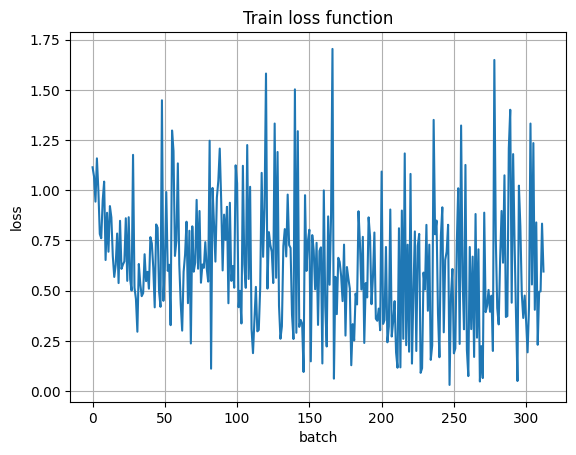

In [38]:
import matplotlib.pyplot as plt
import numpy as np

loss_array_smaller = [x for i, x in enumerate(loss_array) if i%400==0]

fig, ax = plt.subplots()
ax.plot(range(len(loss_array_smaller)), loss_array_smaller)

ax.set(xlabel='batch', ylabel='loss',
       title='Train loss function')
ax.grid()

fig.savefig("test_512_10_epochs_50k.png")
plt.show()

In [9]:
torch.cuda.empty_cache()

load = "models/"

with open(load+"vocab.json", 'r') as file:
    char2int = json.load(file)
    char2int['<PAD>'] = 0
    int2char = {v:k for k,v in char2int.items()}
model = MeanClassifier(vocab=char2int, emb_dim=256,
                    hid_dim=128)
model.load_state_dict(torch.load(load+"model.pt", map_location=device))
model.to(device)

MeanClassifier(
  (embed): Embedding(1187688, 256, padding_idx=0)
  (linear_hid1): Linear(in_features=256, out_features=128, bias=True)
  (linear_hid2): Linear(in_features=128, out_features=128, bias=True)
  (linear_hid3): Linear(in_features=128, out_features=128, bias=True)
  (linear_out): Linear(in_features=128, out_features=3, bias=True)
)

In [11]:
vocab = model.vocab

In [34]:
def predict(text, tokenizer=None, unk="<UNK>"):
    model.eval()
    tokenizer = tokenizer or str.split
    tokenized = tokenizer(text)
    tokens = torch.tensor([[vocab.get(x, vocab[unk]) for x in tokenized]], device=device)
    res = model(tokens)[0]
    arg_to_name = {0: "neutral", 1: "positive", 2: "negative"}
    return res, arg_to_name[res.argmax().item()]

In [44]:
def predict_tokens(tokens_, tokenizer=None, unk="<UNK>"):
    model.eval()
    tokens = tokens_[0][None, :].to(device)
    res = model(tokens)[0]
    arg_to_name = {0: "neutral", 1: "positive", 2: "negative"}
    return res, arg_to_name[res.argmax().item()], arg_to_name[tokens_[1]]

In [19]:
def predict_emb(text, tokenizer, unk="<unk>"):
    model.eval()
    tokenizer = tokenizer or str.split
    tokens = tokenizer(text).mean(0)[None, :].to(device)
    res = model(tokens)
    arg_to_name = {0: "neutral", 1: "positive", 2: "negative"}
    return res, arg_to_name[res.argmax().item()]

In [20]:
def predict_emb_tokenized(dataset_input, unk="<unk>"):
    model.eval()
    tokens = dataset_input[0][None, :].to(device)
    res = model(tokens)
    arg_to_name = {0: "neutral", 1: "positive", 2: "negative"}
    return res, arg_to_name[res.argmax().item()], arg_to_name[dataset_input[1]]

In [21]:
predict_emb_tokenized(dataset[0])

(tensor([[-0.7414,  0.4673, -0.3371]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 'positive',
 'positive')

In [22]:
df_id = 30010
arg_to_name = {0: "neutral", 1: "positive", 2: "negative"}
res = predict_emb(df['text'][df_id], tokenizer)

print(df['text'][df_id])
print("-"*100)
print("Original: ", arg_to_name[df['sentiment'][df_id]])
print("Predicted: ", res[1])
print("Logits: ", res[0])

NameError: name 'df' is not defined

In [48]:
# predict(dataset[0][0])

In [49]:
# predict_tokens(dataset[0])

In [58]:
from sklearn.metrics import f1_score, confusion_matrix

res = []
for x in tqdm(range(50000, 70000)):
    res.append(predict_emb(df["text"].iloc[x], tokenizer))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:22<00:00, 243.88it/s]


In [60]:
confusion_matrix([arg_to_name[x] for x in df['sentiment'].iloc[50000:70000]], [x[1] for x in res])

array([[3713,  766,  891],
       [ 358, 3119, 1627],
       [ 641, 1437, 7448]], dtype=int64)

In [61]:
from collections import Counter
Counter([x[1] for x in res])

Counter({'positive': 9966, 'neutral': 5322, 'negative': 4712})

In [63]:
f1_score([arg_to_name[x] for x in df['sentiment'].iloc[50000:70000]], [x[1] for x in res], average="micro")

0.714